# 数据加载和预处理
## 下载安装包
- scikit-mage : 用于图像的I/O和变换
- pandas : 用于更容易地进行csv解析

In [1]:
from __future__ import print_function, division # __future__是python2引用python3特性的包
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms,utils
import torch

# 忽略警告
import warnings

warnings.filterwarnings("ignore")

plt.ion() # interactive mode

## 下载数据集
[click here](https://download.pytorch.org/tutorial/faces.zip)，来下载数据集，并将数据集存储到./dataset/face/目录下。这个数据集实际上是imagenet数据集标注为face的图片当中在dlib面部检测(dlib's pose estimation) 表现良好的图片。我们要处理的是一个面部姿态的数据集。也就是按如下方式标注的人脸：

![figure.1](https://gitee.com/zyp521/upload_image/raw/master/55IsS6.png)

### 数据集注释
数据集是按如下规则打包成csv文件：  
```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y0805personali01.jpg,27,83,27,98, ... 84,1341084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```

## 读取数据集
将csv中的标注点数据读入到(N,2)数组中，其中N是特征点的数量。具体代码如下：

In [2]:
# laod csv to DataFrame
landmarks = pd.read_csv(os.path.join('face/face_landmarks.csv'))

n = 65 # 65 images
# 参考上述格式
image_name = landmarks.iloc[n,0] # image name
landmark = landmarks.iloc[n, 1:].values# transfer images to matrix
landmark = landmark.astype('float').reshape(-1,2) # 转换为[m,2]浮点数坐标格式

print('Image name : {name}'.format(name=image_name))
print('Landmarks shape : {shape}'.format(shape=landmark.shape))
print('First 4 Landmarks : {mark}'.format(mark=landmark[:4]))

Image name : person-7.jpg
Landmarks shape : (68, 2)
First 4 Landmarks : [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


## 编写函数
写一个简单函数来展示一张图片和它对应的标注点作为例子。

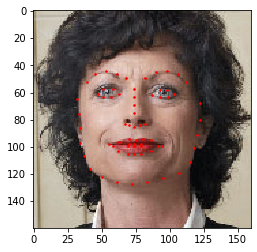

In [3]:
def show_landmarks(image,landmarks):
    """
    显示带有标点的图片 
    image: input image
    landmarks: landmark
    """
    plt.imshow(image)
    plt.scatter(landmarks[:,0],landmarks[:,1],s=10,marker='.',c='r')
    plt.pause(0.001) # 暂停一下来显示绘图更新
    
plt.figure()
show_landmarks(io.imread(os.path.join('face/',image_name)),landmark)
plt.show()

## 数据集类
torch.util.data.Dataset是表示数据集的抽象类，因此**自定义数据集应继承Dataset**并覆盖一下方法__len__实现len(dataset)返回数据集的尺寸，__getitem__用来获取一些索引数据，例如：dataset[i]中的i。  
### 建立数据集类
为面部数据集创建一个数据集类。我们将在 __init__ 中读取csv的文件内容，并在 __getitem__ 中读取图片。这么做是为了节省内存空间，只有当用到图片的时候才去读取他而不是把图片全部存进内存中。  

我们的数据样本将按这样一个字典{'image':image, 'landmarks':landmarks}组织。我们的数据集类将添加一个可选参数**transform**以方便对样本进行处理。  
下面是数据集类：

In [4]:
class FaceLandmarksDataset(Dataset):
    """
    面部标记数据集
    """
    def __init__(self, csv_file, root_dir, transform=None):
        """
        初始化函数
        csv_file : csv文件路径
        root_dir : 图像文件目录
        transform : 一个样本上的可用的可选变换
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.landmarks_frame.iloc[index,0])
        image = io.imread(image_path)
        if image.shape[2] == 2:
            print(image.shape)
            image = np.expand_dims(image, axis=0)
        landmarks = self.landmarks_frame.iloc[index,1:].values
        # landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1,2)
        
        sample = {'image':image, 'landmarks':landmarks}
        
        if self.transform:
            sample = self.transform(sample) # 图像正则化、均一化等
        
        return sample

## 数据可视化
实例化这个类并遍历数据样本，我们将会打印出前四个例子的尺寸并展示标注的特征点。  
如图所示：

图片-0, 图片维度 - (324, 215, 3), 标注点个数 - 68


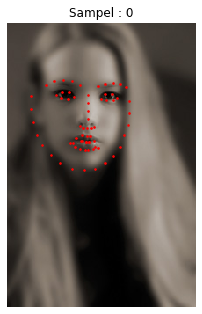

图片-1, 图片维度 - (500, 333, 3), 标注点个数 - 68


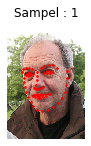

图片-2, 图片维度 - (250, 258, 3), 标注点个数 - 68


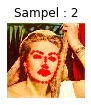

图片-3, 图片维度 - (434, 290, 3), 标注点个数 - 68


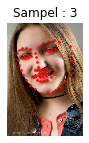

In [5]:
face_dataset = FaceLandmarksDataset(csv_file='face/face_landmarks.csv',root_dir='face/')

figure = plt.figure(figsize=(12,5))

for i in range(len(face_dataset)):
    temp = face_dataset[i] 
    print('图片-{index}, 图片维度 - {image_shape}, 标注点个数 - {landmark_num}'.format(index=i,
                                                                            image_shape = temp['image'].shape,
                                                                            landmark_num = temp['landmarks'].shape[0]))
    t = plt.subplot(1,4,i+1)
    plt.tight_layout()
    t.set_title('Sampel : {index}'.format(index = i))
    t.axis('off')
    show_landmarks(temp['image'],temp['landmarks'])
    
    if i == 3:
        plt.show()
        break

## 数据变换
通过上面的例子，我们会发现图片并不是相同的尺寸，绝大多数神经网络都是假定图片的尺寸相同，因此我们需要做一些预处理。让我们创建三个转换： Rescale : 缩放图片、 RandomCrop : 对图片进行随机裁剪、ToTensor : 把numpy格式图片转为torch格式图片。  

们会把它们写成可调用的类的形式，而不是简单地函数，这样就不需要每次调用时传递一遍参数。我们只需要实现 __call__ 方法，必要时实现 __init__ 方法。我们可以这样调用这些转换：

```
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

观察下面这些转化是如何应用到图像和标签上的。

### 缩放图片

In [6]:
class Rescale(object):
    """
    将样本中图像重新缩放到给定大小
    
    Args: 
        output_size : 所需要的大小，如果是元组, 则输出为与output_size匹配。
        如果是int，则匹配较小的图像边缘到output_size保持纵横比相同。
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size,(int,tuple)) # 验证是int还是tuple
        self.output_size = output_size
    
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2] # 得到纵横比
        # 如果为整形，则将长宽较大的那个等于output_size，将较小的那个调整成纵横比相同的值。
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else: # 如果为tuple，则按照元组内容调整
            new_h,new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        # resize image
        image_resize = transform.resize(image, (new_h, new_w)) # 调用skicit image中 transform
        
        # 按照新生成的图像比调整标注
        landmarks_resize = landmarks * [new_w / w, new_h / h]
        
        return {'image': image_resize, 'landmarks':landmarks_resize}

### 随机图像裁剪

In [7]:
class Rescale(object):
    """
    将样本中图像重新缩放到给定大小

    Args:
        output_size : 所需要的大小，如果是元组, 则输出为与output_size匹配。
        如果是int，则匹配较小的图像边缘到output_size保持纵横比相同。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))  # 验证是int还是tuple
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]  # 得到纵横比
        # 如果为整形，则将长宽较大的那个等于output_size，将较小的那个调整成纵横比相同的值。
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:  # 如果为tuple，则按照元组内容调整
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        # resize image
        image_resize = transform.resize(image, (new_h, new_w))  # 调用skicit image中 transform

        # 按照新生成的图像比调整标注
        landmarks_resize = landmarks * [new_w / w, new_h / h]

        return {'image': image_resize, 'landmarks': landmarks_resize}


class RandomCrop(object):
    """随机裁剪样本的图像

    Args:
        output_size : 所需要的输出的大小，如果是int，则为方形裁剪。
        注意裁剪起始点是随机生成的
    """

    # 初始化
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))  # 安全性验证

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        # load data
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]

        new_h, new_w = self.output_size

        # random clip original point
        high = np.random.randint(0, h - new_h)
        weight = np.random.randint(0, w - new_w)
        # clip image and landmarks
        image = image[high: high + new_h, weight: weight + new_w]
        # 将不在图像范围内的点设置为(-1,-1) 在后续绘图时处理，这里主要是保证在dataloader中每个图像对应点的维度相同，才不会报错。
        # 如果维度不同的话，一个张图有56个点，一张图有64个点，会导致在dataloader中enumerate时报错，无法读取
        for i in landmarks:
            if i[0] > weight and i[0] < weight + new_w and i[1] > high and i[1] < high + new_h:
                pass
            else:
                i[0] = -1
                i[1] = -1

        # 由于已经对图片进行了裁剪，图像之前标注点的位置也应该要发生移动，裁剪后的图片需要标注的点的原点发生了移动
        landmarks = np.array(landmarks) - [weight, high]

        return {'image': image, 'landmarks': landmarks}

### 转换为Tensor

In [8]:
class ToTensor(object):
    """
    将样本中的ndarray转换为tensor
    """
    
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # 交换颜色轴因为numpy包的图片是H*W*C, 而torch包的图片是C*H*W
        image = image.transpose((2,0,1)) 
        return {'image':torch.from_numpy(image),'landmarks':torch.from_numpy(landmarks)}

## 组合转换
接下来我们把这些转换应用到一个例子上。

我们想要把图像的短边调整为256，然后随机裁剪为224大小的正方形。也就是说先进行图像缩放然后在进行图像裁剪两种变换。我们可以使用组合的方式来进行，调用一个简单的类torchvision.transforms.Compose来实现这一操作。

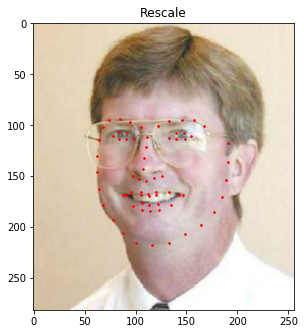

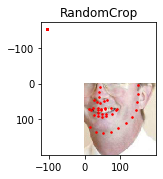

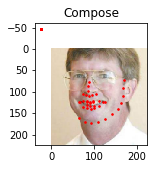

In [9]:
# create object
scale = Rescale(256)
crop = RandomCrop(200)

# compose operations
compose = transforms.Compose([Rescale(256),RandomCrop(224)])

# load data
sample = face_dataset[64]

# plot
plt.figure(figsize=(12,5))
for i, tsfm in enumerate([scale,crop,compose]):
    transform_sample = tsfm(sample)
    
    plt.subplot(1,3,i+1)
    plt.tight_layout() # 自动调整子图参数使其充满区域
    plt.title(type(tsfm).__name__)
    show_landmarks(transform_sample['image'],transform_sample['landmarks'])
    

## 迭代数据集
让我们把这些整合起来以创建一个带组合转换的数据集。总结一下，每次这个数据集被采样时：1.能及时地从文件中读取图片 2.对读取的图片应用转换 3.由于其中一部操作是随机的裁剪，数据被增强了。  

我们可以像之前那样使用 for i in range 循环来对所有创建的数据集执行同样的操作。

In [10]:
# 将数据集转换为指定格式
transformed_dataset = FaceLandmarksDataset(csv_file='face/face_landmarks.csv',
                                          root_dir='face/',
                                          transform=transforms.Compose([
                                              Rescale(256),
                                              RandomCrop(224),
                                              ToTensor()
                                          ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print('序号 - {index}, 图像大小 - {c}×{w}×{h}, 图像标注点个数 - {landmark_size}'.format(index=i,
                                                                                c=sample['image'].size()[0],
                                                                                w=sample['image'].size()[1],
                                                                                h=sample['image'].size()[2],
                                                                                landmark_size=sample['landmarks'].size()[0]))
    
    if i == 3:
        break


序号 - 0, 图像大小 - 3×224×224, 图像标注点个数 - 68
序号 - 1, 图像大小 - 3×224×224, 图像标注点个数 - 68
序号 - 2, 图像大小 - 3×224×224, 图像标注点个数 - 68
序号 - 3, 图像大小 - 3×224×224, 图像标注点个数 - 68


但是，对所有数据集简单的使用 for 循环牺牲了许多功能，尤其是批量处理数据、打乱数据、使用多线程multiprocessingworker并行加载数据。  

torch.utils.data.Dataloader 是一个提供上述所有这些功能的迭代器。下面使用的参数必须是清楚地。一个值得关注的参数是collate_fn，可以通过它来决定如何对数据进行批处理。但是绝大多数情况下默认值就能运行良好。

块号 - 0, 块图内片数 - 4, 图像大小 - 3×224×224, 图像标注点 - <built-in method size of Tensor object at 0x1c2b113320>


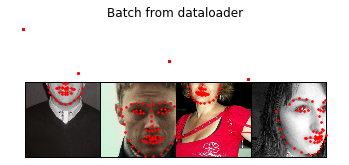

In [12]:
dataloader = DataLoader(transformed_dataset,batch_size=4,shuffle=True,drop_last=True,num_workers=4)


# 辅助功能：显示批次
def show_landmarks_batch(sample_batched):
    """
    展示batch中带有标注的图片示例
    """

    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_length = len(images_batch)
    image_size = images_batch.size(2)  # batch结构[num,channel,weight,hight]
    grid_border_size = 2
    # 绘制网格图像：将图像结合到一起的
    grid = utils.make_grid(images_batch)
    grid = grid.numpy()
    plt.imshow(grid.transpose(1,2,0))  # 由于numpy向量和torch向量顺序不同因此要转换


    # 去除之前设置为0的点
    landmarks_batch_list = []
    for i in range(batch_length):
        temp = []
        for j in range(len(landmarks_batch[i])):
            if landmarks_batch[i][j][0] != -1 and landmarks_batch[i][j][1] != -1:
                temp.append([landmarks_batch[i][j][0],landmarks_batch[i][j][1]])
        landmarks_batch_list.append(temp)

    landmarks_batch = np.array(landmarks_batch_list)

    for i in range(batch_length):
        plt.scatter(landmarks_batch[i, :, 0] + i * image_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1] + grid_border_size, s=10, marker='.', c='r')

        plt.title('Batch from dataloader')


for i_batch, sample_batched in enumerate(dataloader):
    print('块号 - {index}, 块图内片数 - {n}, 图像大小 - {c}×{w}×{h}, 图像标注点 - {landmark_size}'.format(index=i_batch,
                                                                               n=sample_batched['image'].size(0),
                                                                               c=sample_batched['image'].size(1),
                                                                               w=sample_batched['image'].size(2),
                                                                               h=sample_batched['image'].size(3),
                                                                               landmark_size=sample_batched[
                                                                                   'landmarks'].size))

    if i == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Torchvison
torchvision 包提供了常用的数据集(dataset)和转换(transforms)。你可能不需要自己构造这些类。torchvision 中还有一个更常用的数据集类ImageFolder。它假定了数据集是以如下方式构造的：

```
root/ants/xxx.png
root/antx/xxy.jpeg
root/antx/xxz.png
...
root.bees/123.jpg
root/bees/nsdf.png
root/bees/asd932.png
```

其中'ants','bees'等式分类标签。在PIL.Image中你也可以使用类似的转换(transform)，例如：RandomHorizontalFilp，Scale等，利用这些你可以按如下的方式创建一个数据加载器(dataloader)：

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                          transform = data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,batch_size=4,shuffle=True,num_workers=4)